<a href="https://colab.research.google.com/github/kennydukor/BIRME/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone Dependent files

In [ ]:
!git clone "http://github.com/"

Import required files

In [9]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [7]:
# Root directory for dataset (from google drive)
dataroot = "/content/drive/MyDrive/Dataset/birme"

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64 #128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [4]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

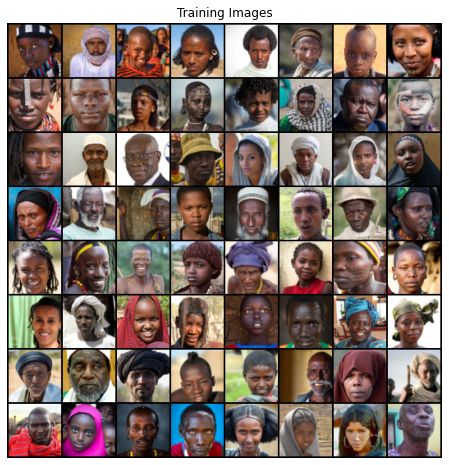

In [10]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))